In [ ]:
import pyodbc
import json

with open("contrasena.json", "r") as file:
    data = json.load(file)

# Set up your connection string
server = data['server']
database = data['database']
username = data['username']
password = data['password']  # Replace with your actual password

# Define the connection string for SQL Server (Azure)
conn_str = (
    f'DRIVER={{ODBC Driver 17 for SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={username};'
    f'PWD={password}'
)

# Establish the connection
try:
    conn = pyodbc.connect(conn_str)
    print("Connected to the Azure SQL Database successfully!")

except pyodbc.Error as e:
    print(f"Error connecting to the database: {e}")


query = "SELECT * FROM SalesLT.customer"

Connected to the Azure SQL Database successfully!


In [11]:
import pandas as pd
data1 = pd.read_sql(query, conn)
data1.head()

/var/folders/hd/5tgzp1p13vzdw6_tpz44xpsw0000gn/T/ipykernel_26357/1338613891.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data1 = pd.read_sql(query, conn)


,CustomerID,NameStyle,Title,FirstName,MiddleName,LastName,Suffix,CompanyName,SalesPerson,EmailAddress,Phone,PasswordHash,PasswordSalt,rowguid,ModifiedDate
0,1,False,Mr.,Orlando,N.,Gee,None,A Bike Store,adventure-works\pamela0,orlando0@adventure-works.com,245-555-0173,L/Rlwxzp4w7RWmEgXX+/A7cXaePEPcp+KwQhl2fJL7w=,1KjXYs4=,3F5AE95E-B87D-4AED-95B4-C3797AFCB74F,2005-08-01
1,2,False,Mr.,Keith,None,Harris,None,Progressive Sports,adventure-works\david8,keith0@adventure-works.com,170-555-0127,YPdtRdvqeAhj6wyxEsFdshBDNXxkCXn+CRgbvJItknw=,fs1ZGhY=,E552F657-A9AF-4A7D-A645-C429D6E02491,2006-08-01
2,3,False,Ms.,Donna,F.,Carreras,None,Advanced Bike Components,adventure-works\jillian0,donna0@adventure-works.com,279-555-0130,LNoK27abGQo48gGue3EBV/UrlYSToV0/s87dCRV7uJk=,YTNH5Rw=,130774B1-DB21-4EF3-98C8-C104BCD6ED6D,2005-09-01
3,4,False,Ms.,Janet,M.,Gates,None,Modular Cycle Systems,adventure-works\jillian0,janet1@adventure-works.com,710-555-0173,ElzTpSNbUW1Ut+L5cWlfR7MF6nBZia8WpmGaQPjLOJA=,nm7D5e4=,FF862851-1DAA-4044-BE7C-3E85583C054D,2006-07-01
4,5,False,Mr.,Lucy,None,Harrington,None,Metropolitan Sports Supply,adventure-works\shu0,lucy0@adventure-works.com,828-555-0186,KJqV15wsX3PG8TS5GSddp6LFFVdd3CoRftZM/tP0+R4=,cNFKU4w=,83905BDC-6F5E-4F71-B162-C98DA069F38A,2006-09-01


In [12]:
data1.columns

Index(['CustomerID', 'NameStyle', 'Title', 'FirstName', 'MiddleName',
       'LastName', 'Suffix', 'CompanyName', 'SalesPerson', 'EmailAddress',
       'Phone', 'PasswordHash', 'PasswordSalt', 'rowguid', 'ModifiedDate'],
      dtype='object')

In [15]:
for col in data1.columns:
    if data1[col].isnull().sum() > 0:
        print(f"Column '{col}' has {data1[col].isnull().sum()} null values.")
        data1.drop(columns=col, inplace=True)

Column 'Title' has 7 null values.
Column 'MiddleName' has 343 null values.
Column 'Suffix' has 799 null values.


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [20]:
# Convertir la fecha
data1['ModifiedDateOrdinal'] = pd.to_datetime(data1['ModifiedDate']).map(pd.Timestamp.toordinal)

# Eliminar columnas no útiles
df = data1.drop(['ModifiedDate', 'rowguid', 'PasswordHash', 'PasswordSalt'], axis=1)

# Codificar texto
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna('None')  # Rellenar nulos
    df[col] = LabelEncoder().fit_transform(df[col])

# Separar datos
X = df.drop('ModifiedDateOrdinal', axis=1)
y = df['ModifiedDateOrdinal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Entrenar modelo
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluar
print("Score:", model.score(X_test, y_test))

Score: 0.5719015855123907


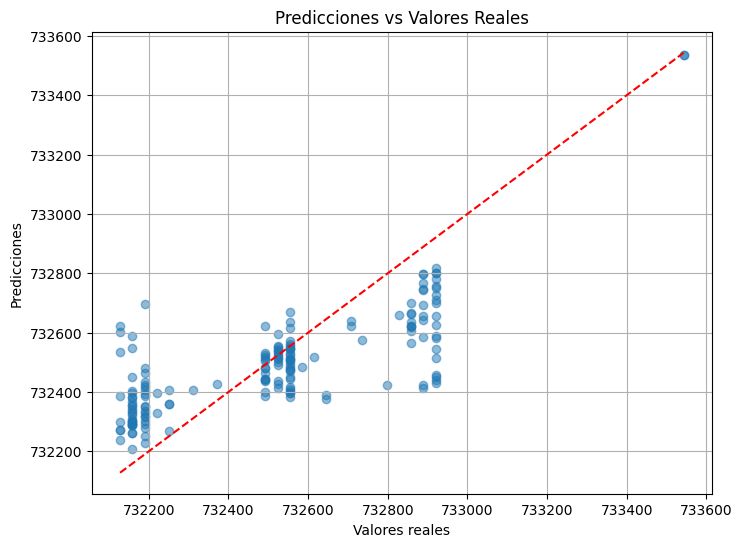

In [22]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Línea de referencia
plt.grid(True)
plt.show()

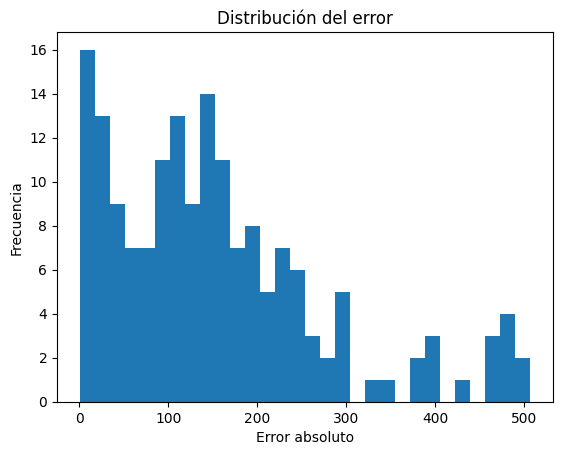

In [23]:
import numpy as np

errors = np.abs(y_test - y_pred)

plt.hist(errors, bins=30)
plt.xlabel("Error absoluto")
plt.ylabel("Frecuencia")
plt.title("Distribución del error")
plt.show()

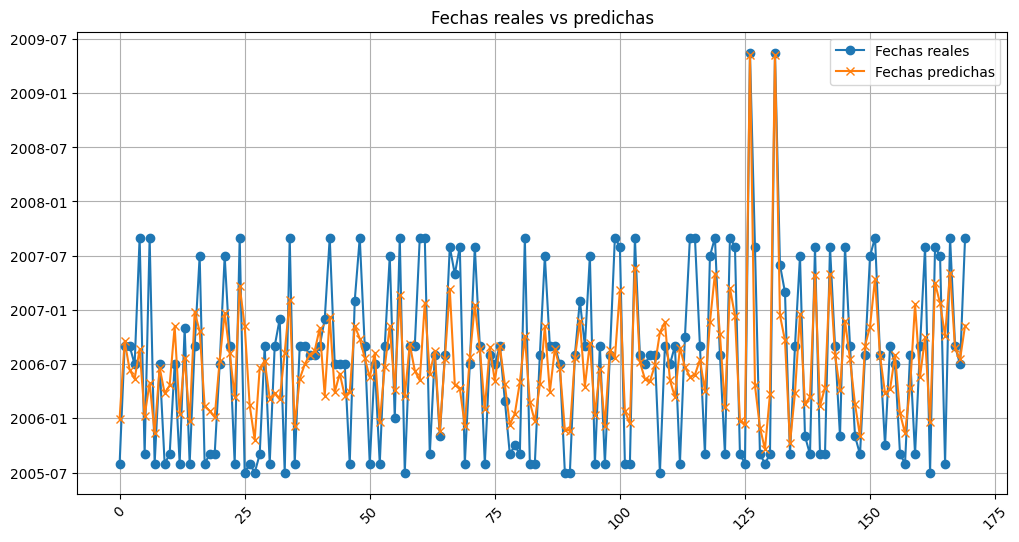

In [24]:
real_dates = pd.to_datetime(y_test.map(pd.Timestamp.fromordinal))
pred_dates = pd.to_datetime(pd.Series(y_pred).map(lambda x: pd.Timestamp.fromordinal(int(x))))

plt.figure(figsize=(12, 6))
plt.plot(real_dates.values, label='Fechas reales', marker='o')
plt.plot(pred_dates.values, label='Fechas predichas', marker='x')
plt.legend()
plt.title('Fechas reales vs predichas')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [25]:
import joblib
# Guardar el modelo
joblib.dump(model, 'modelo.pkl')

['modelo.pkl']

In [12]:
conn.close()